In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

Key Points Using Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_styled_landmarks(image, results):
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=1, circle_radius=3), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=1, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=1, circle_radius=3), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=1, circle_radius=1)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=1, circle_radius=3), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=1, circle_radius=1)
                             ) 

Extract Keypoint Values

In [5]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

Setup Folders for Collection

In [ ]:
# Path for exported data, numpy arrays
path = os.getcwd()
DATA_PATH = os.path.join('MP_Data') 
# VIDEO_PATH = os.path.join('Video_Data')

# Actions that we try to detect
actions = np.array(['halo', 'selamat pagi', 'selamat siang', 'selamat sore', 'selamat malam',
                    'apa kabar', 'sampai jumpa lagi', 'perkenalkan', 'aku', 'kamu', 
                    'maaf', 'tolong', 'terima kasih', 'sama-sama', 'ya', 'tidak', 'mau', 
                    'tidak mau', 'suka', 'makanan'])

# num videos worth of data
no_sequences = 20

# Videos are going to be num frames in length
sequence_length = 20

In [8]:
# for action in actions: 
#     action_path = os.path.join(DATA_PATH, action)
#     video_path = os.path.join(VIDEO_PATH, action)
    
#     # Check if the directory exists
#     if not os.path.exists(action_path):
#         os.makedirs(action_path)
#     if not os.path.exists(video_path):
#         os.makedirs(video_path)
    
#     # If directory exists, find the max folder number
#     dirmax = np.max(np.array([int(folder) for folder in os.listdir(action_path)])) if os.listdir(action_path) else 0
    
#     for sequence in range(no_sequences):
#         try: 
#             os.makedirs(os.path.join(DATA_PATH, action, str(dirmax + sequence)))
#         except Exception as e:
#             print(f"Error creating directory: {e}")

Create Video Samples

In [9]:
# # Loop through actions
# action = actions[0]
# no_videos = 5
# fps = sequence_length
# duration = 3
# frame_width = 640  
# frame_height = 480  
# output_dir = os.path.join(VIDEO_PATH, action) # Directory to save videos

# # Capture video from webcam
# cap = cv2.VideoCapture(0)

# # Ensure the camera is opened successfully
# if not cap.isOpened():
#     print("Error: Could not open video stream.")
#     exit()

# # Loop through 5 videos
# for video_num in range(no_videos):
#     # Define the video file path
#     video_path = os.path.join(output_dir, f'{action}_{video_num}.mp4')

#     # Define the codec and create VideoWriter object to save video in mp4 format
#     fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 format
#     out = cv2.VideoWriter(video_path, fourcc, fps, (frame_width, frame_height))

#     # Capture video frames for the duration specified
#     total_frames = fps * duration

#     for frame_num in range(total_frames):
#         # Read frame from webcam
#         ret, frame = cap.read()

#         if not ret:
#             print(f"Error: Could not read frame {frame_num} of video {video_num}.")
#             break

#         if frame_num == 0: 
#             cv2.putText(frame, 'STARTING COLLECTION', (120,200), 
#                         cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
#             cv2.putText(frame, 'Collecting frames for {} Video Number {}'.format(action, no_videos), (15,12), 
#                         cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
#             # Show to screen
#             cv2.imshow('OpenCV Feed', frame)
#             cv2.waitKey(2000)
#         else: 
#             cv2.putText(frame, 'Collecting frames for {} Video Number {}'.format(action, no_videos), (15,12), 
#                         cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
#             # Show to screen
#             cv2.imshow('OpenCV Feed', frame)

#         # Save the frame to the video file
#         out.write(frame)

#         # Break if 'q' is pressed to stop early
#         if cv2.waitKey(10) & 0xFF == ord('q'):
#             break

#     # Release the VideoWriter object after each video
#     out.release()
#     print(f"Video {video_num} saved at {video_path}")

# # Release the capture and close all windows
# cap.release()
# cv2.destroyAllWindows()

Collect Keypoint Values for Training and Testing

In [10]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    # Loop through actions
    action = actions[17]
    # Loop through sequences aka videos
    for sequence in range(no_sequences):
        # Loop through video length aka sequence length
        for frame_num in range(sequence_length):

            # Read feed
            ret, frame = cap.read()

            # Make detections
            image, results = mediapipe_detection(frame, holistic)

            # Draw landmarks
            draw_styled_landmarks(image, results)
            
            # NEW Apply wait logic
            if frame_num == 0: 
                cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                # Show to screen
                cv2.imshow('OpenCV Feed', image)
                cv2.waitKey(2000)
            else: 
                cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                # Show to screen
                cv2.imshow('OpenCV Feed', image)
            
            # NEW Export keypoints
            keypoints = extract_keypoints(results)
            npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
            np.save(npy_path, keypoints)

            # Break gracefully
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
            
    cap.release()
    cv2.destroyAllWindows()

In [11]:
cap.release()
cv2.destroyAllWindows()

Preprocess Data and Create Labels and Features

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [7]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

NameError: name 'actions' is not defined

In [9]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [10]:
np.array(sequences).shape

(400, 20, 258)

In [11]:
np.array(labels).shape

(400,)

In [12]:
X = np.array(sequences)
X.shape

(400, 20, 258)

In [13]:
y = to_categorical(labels).astype(int)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [15]:
y_test.shape

(20, 20)

Build and Train LSTM Neural Network

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [17]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(20,258)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [18]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [19]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)
import tensorflow as tf

class EarlyStoppingByAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, monitor='categorical_accuracy', value=0.99, verbose=1):
        super(EarlyStoppingByAccuracy, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is not None:
            if current > self.value:
                if self.verbose > 0:
                    print(f"\nEpoch {epoch + 1}: Early stopping as {self.monitor} reached {current:.4f}")
                self.model.stop_training = True


In [20]:
# model.fit(X_train, y_train, epochs=100, callbacks=[tb_callback])
history = model.fit(X_train, y_train, epochs=500, callbacks=[tb_callback, EarlyStoppingByAccuracy()])

Epoch 1/500


12/12 [==============================] - 24s 75ms/step - loss: 2.9305 - categorical_accuracy: 0.0447
Epoch 2/500
12/12 [==============================] - 1s 77ms/step - loss: 2.6648 - categorical_accuracy: 0.1368
Epoch 3/500
12/12 [==============================] - 1s 76ms/step - loss: 2.6196 - categorical_accuracy: 0.1658
Epoch 4/500
12/12 [==============================] - 1s 84ms/step - loss: 2.6542 - categorical_accuracy: 0.1605
Epoch 5/500
12/12 [==============================] - 1s 83ms/step - loss: 2.5221 - categorical_accuracy: 0.2184
Epoch 6/500
12/12 [==============================] - 1s 98ms/step - loss: 2.5078 - categorical_accuracy: 0.2211
Epoch 7/500
12/12 [==============================] - 1s 78ms/step - loss: 2.3889 - categorical_accuracy: 0.2632
Epoch 8/500
12/12 [==============================] - 1s 78ms/step - loss: 2.3089 - categorical_accuracy: 0.2842
Epoch 9/500
12/12 [==============================] - 1s 86ms/step - loss: 2.3113 - categorical_accura

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 64)            82688     
                                                                 
 lstm_1 (LSTM)               (None, 20, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 20)                660       
                                                                 
Total params: 237812 (928.95 KB)
Trainable params: 23781

Make Predictions

In [22]:
res = model.predict(X_test)

1/1 [==============================] - 2s 2s/step


In [23]:
actions[np.argmax(res[6])]

'tolong'

In [24]:
actions[np.argmax(y_test[6])]

'tolong'

Save Weights

In [28]:
print(model.get_config())  # This will display the model configuration

{'name': 'sequential', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 20, 258), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'lstm_input'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 20, 258), 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'time_major': False, 'units': 64, 'activation': 'relu', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'recurrent_initializer': {'module': 'keras.initializers', 'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registere

In [32]:
config = model.get_config()
# Remove the time_major argument from the LSTM layers if present
for layer in config['layers']:
    if 'time_major' in layer['config']:
        del layer['config']['time_major']

# Rebuild the model using the modified configuration
new_model = Sequential.from_config(config)

# Load weights from the original model
new_model.set_weights(model.get_weights())

# Save the updated model
new_model.save('my_model_no_timemajor.h5')

d:\python\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
model.save('my_model.h5')

d:\python\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
model.save('my_model.keras')

In [35]:
from tensorflow.keras.models import load_model
model = load_model('my_model.h5')

In [37]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, 'tfjs_model')

NotFoundError: d:\python\Lib\site-packages\tensorflow_decision_forests\tensorflow\ops\inference\inference.so not found

In [59]:
model.load_weights('my_model.keras')

Convert model to jason

Evaluation using Confusion Matrix and Accuracy

In [25]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [26]:
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

multilabel_confusion_matrix(ytrue, yhat)

1/1 [==============================] - 0s 115ms/step


array([[[19,  0],
        [ 0,  1]],

       [[19,  0],
        [ 0,  1]],

       [[19,  0],
        [ 0,  1]],

       [[17,  0],
        [ 0,  3]],

       [[17,  0],
        [ 1,  2]],

       [[19,  0],
        [ 0,  1]],

       [[19,  0],
        [ 1,  0]],

       [[17,  2],
        [ 0,  1]],

       [[17,  0],
        [ 0,  3]],

       [[19,  1],
        [ 0,  0]],

       [[18,  0],
        [ 0,  2]],

       [[19,  0],
        [ 0,  1]],

       [[18,  0],
        [ 1,  1]]], dtype=int64)

In [27]:
accuracy_score(ytrue, yhat)

0.85

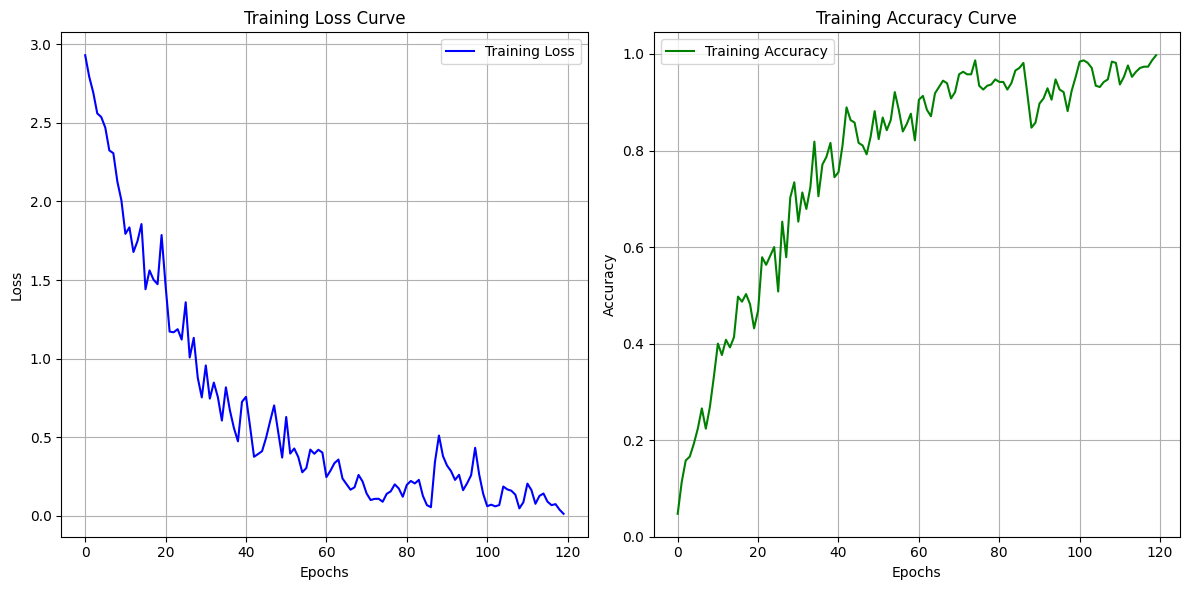

In [29]:
# Plot training loss and training accuracy
plt.figure(figsize=(12, 6))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)

# Plotting training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [30]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

y_true = np.argmax(y_test, axis=1).tolist()
y_pred = np.argmax(res, axis=1).tolist()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\nPrecision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Confusion Matrix:
 [[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1]]

Precision: 0.9166666666666666
Recall: 0.9
F1 Score: 0.8966666666666667


d:\python\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
